In [2]:
pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [3]:
pip install lightweight_mmm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.2/105.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.0/285.0 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 23.0 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.9.0 requires matplotlib>=3.7.1, but you have matplotlib 3.6.1 which is incompatible.


# Importing Necessary libraries

In [113]:
import jax.numpy as jnp
import numpy as np
import pandas as pd
import lightweight_mmm
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import preprocessing
from lightweight_mmm import utils
from lightweight_mmm import plot

# Preparing Data Set

In [192]:
media_data, extra_features, target, costs = utils.simulate_dummy_data(
    data_size=260,
    n_media_channels=6,
    n_extra_features=2,
    geos=1)

In [193]:
Media_Impressions = pd.DataFrame(media_data, columns=['Tv', 'Digital', 'FBAds', 'Social Media', 'Offline', 'Other']) #160 rows
Extra_Features = pd.DataFrame(extra_features, columns=['extra_feature1', 'extra_feature2']) #160 rows
Target = pd.DataFrame(target, columns=['Sales']) #160 rows
Costs = pd.DataFrame(costs, columns=['total cost per media unit per channel']) # 3 rows as there are 3 media channels

# Train, Test Split

In [214]:
#Once you have data categorized into Media, Extra Features, Target & Cost continue to split it into train & Test

# Simple split of the data based on time.
split_point = 260 - 50 #

media_data_train = media_data[:split_point] #110 rows #also only using jax.numpy format only
media_data_test = media_data[split_point:] #50 rows

target_train = target[:split_point]#110 rows
target_test = target[split_point:] #50 rows

extra_features_train = extra_features[:split_point] #110 rows
extra_features_test = extra_features[split_point:] #50 rows



# Scaling Train & Test Data

In [215]:
# Scale data

#initialize Scalers
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

#fit & transform the training data
media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

#transform the test data
media_data_test = media_scaler.transform(media_data_test)
extra_features_test = extra_features_scaler.transform(extra_features_test)

#ignoring to transform target_test variable as it is not required

# Building the lightweight MMM model

In [196]:
mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

mmm.fit(media=media_data_train,       #using scaled data to fit the model
        media_prior=costs,
        extra_features=extra_features_train,
        target=target_train,
        media_names = Media_Impressions.columns.to_list(),
        number_warmup=100,
        number_samples=100,
        number_chains=1)

sample: 100%|██████████| 200/200 [01:25<00:00,  2.34it/s, 1023 steps of size 2.62e-03. acc. prob=0.95]


In [197]:
mmm.print_summary() #summary to get r_hat values


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.45      0.14      0.45      0.25      0.69      8.07      1.00
ad_effect_retention_rate[1]      0.32      0.08      0.30      0.18      0.42      8.03      1.35
ad_effect_retention_rate[2]      0.42      0.08      0.41      0.28      0.54      3.99      1.51
ad_effect_retention_rate[3]      0.31      0.12      0.30      0.14      0.52      6.38      0.99
ad_effect_retention_rate[4]      0.66      0.09      0.64      0.55      0.82      5.53      1.05
ad_effect_retention_rate[5]      0.69      0.08      0.70      0.59      0.83      4.42      1.86
     coef_extra_features[0]     -0.06      0.01     -0.06     -0.07     -0.05     30.08      1.02
     coef_extra_features[1]     -0.03      0.01     -0.03     -0.04     -0.02    100.98      0.99
              coef_media[0]      0.01      0.01      0.00      0.00      0.01     22.91      1.04
              coef_

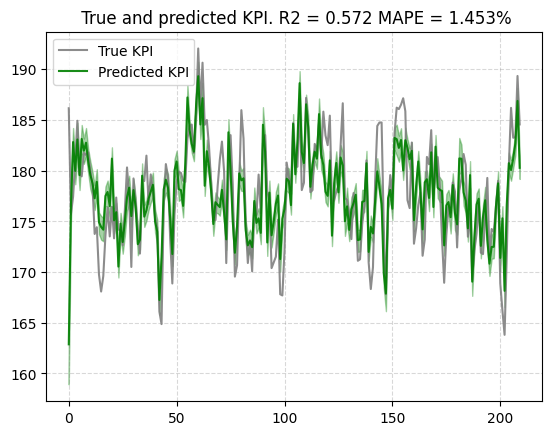

In [198]:
plot.plot_model_fit(media_mix_model=mmm, target_scaler=target_scaler) #check the fit wrt training data

In [211]:
new_predictions = mmm.predict(media=media_data_test, extra_features=extra_features_test, target_scaler = target_scaler ) # predict the values

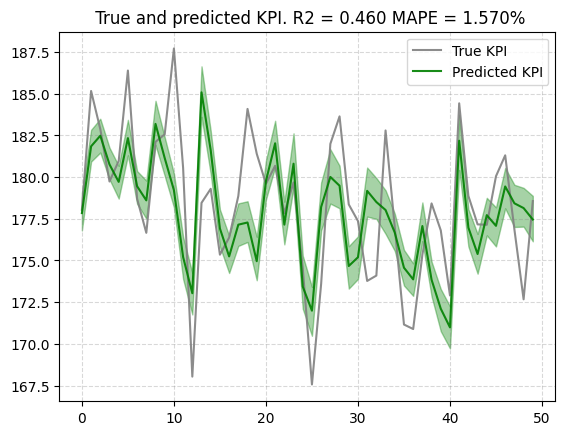

In [217]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions = new_predictions, out_of_sample_target = target_test ) #check the fit wrt test data

# Response curves for Each Channel

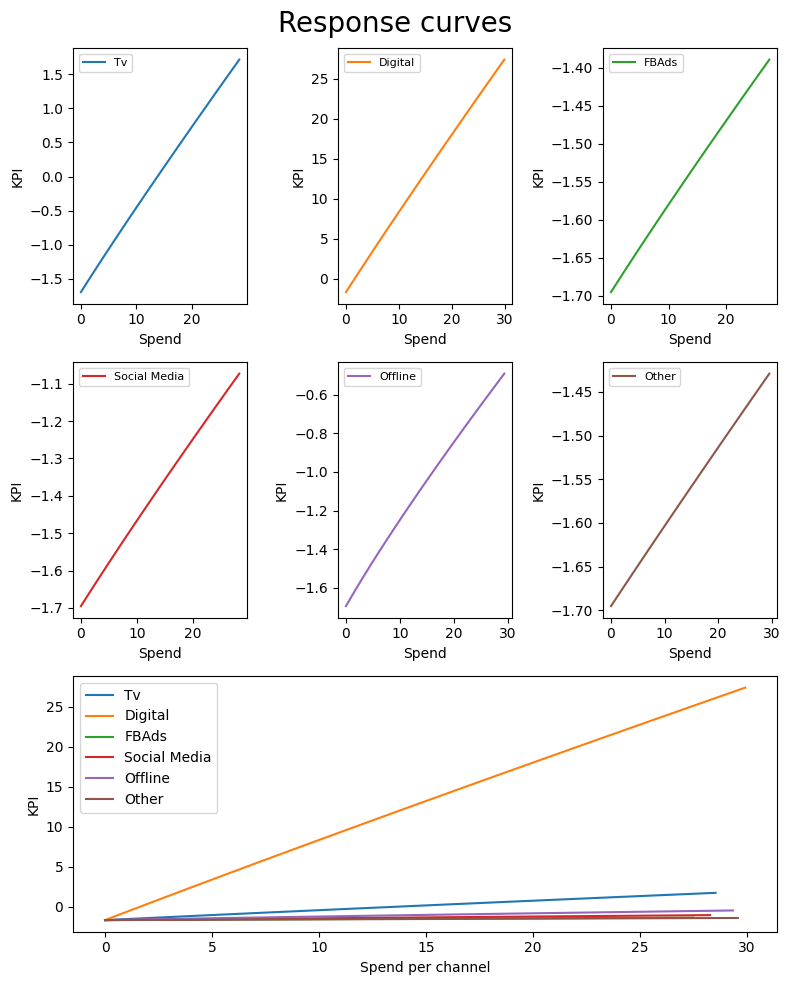

In [219]:
plot.plot_response_curves(
    media_mix_model=mmm, media_scaler = media_scaler, target_scaler=target_scaler)

# Media Effects & ROI

In [222]:
#average media contribution percentage for each channel & roi of each channel calculated as its contribution divided by the cost
media_effect, media_roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler= cost_scaler)

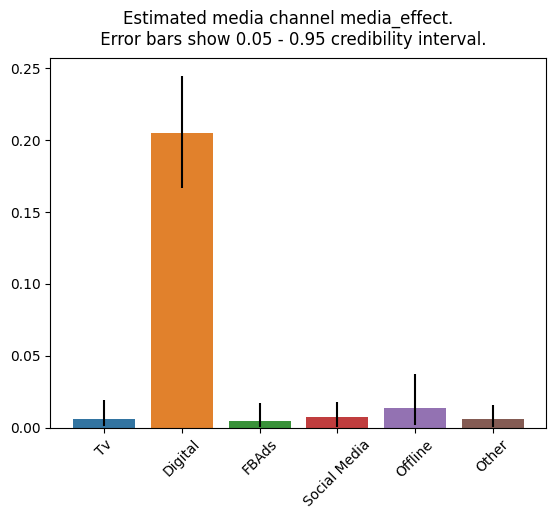

In [224]:
#visualize media effects
plot.plot_bars_media_metrics(metric = media_effect, metric_name= 'media_effect', channel_names = Media_Impressions.columns.to_list() )

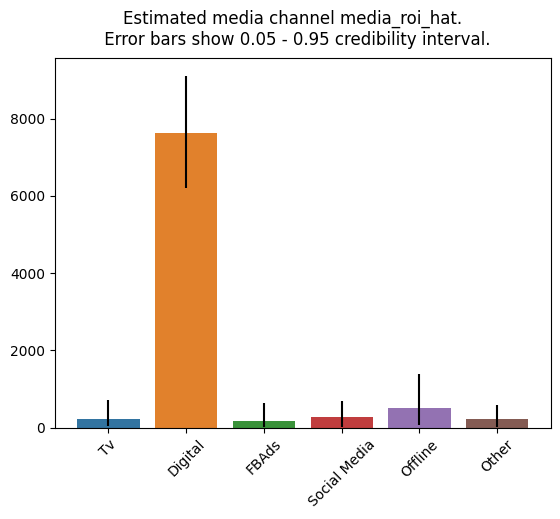

In [225]:
plot.plot_bars_media_metrics(metric = media_roi_hat, metric_name= 'media_roi_hat', channel_names = Media_Impressions.columns.to_list() )

# Baseline Sales Contribution

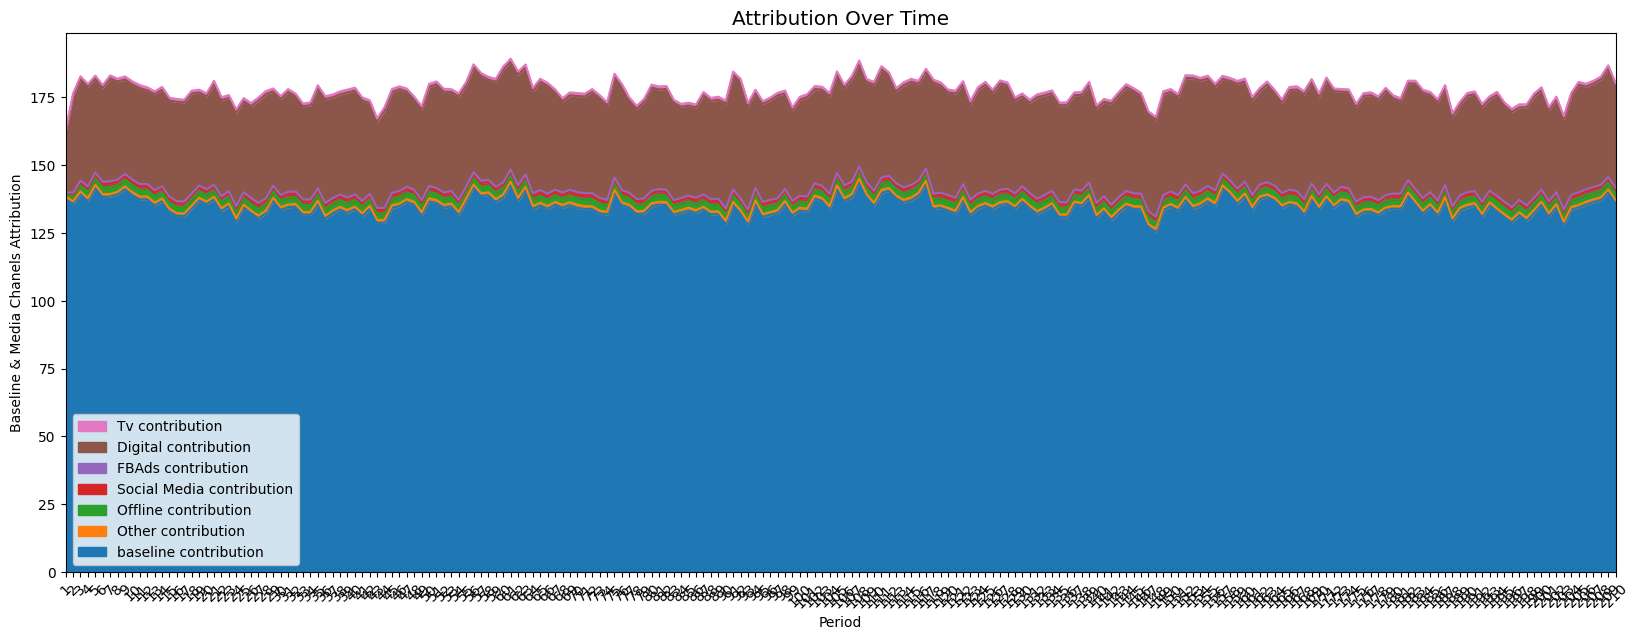

In [248]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model = mmm, target_scaler = target_scaler , channel_names = Media_Impressions.columns.to_list() )

# Budget Optimization

In [226]:
from lightweight_mmm import optimize_media

In [236]:
n_time_periods = 5
weekly_budget = sum(np.mean(media_data,axis = 0)) #mean budget across all the 6 channels
budget = weekly_budget * n_time_periods
extra_features_forecast = extra_features_test[:n_time_periods]  #this is scaled and we are going to predict extra features for next n_time_periods

solution, kpi_without_optim, previous_budget_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    budget=budget,
    prices=costs,
    extra_features = extra_features_forecast,
    media_scaler=media_scaler,
    target_scaler=target_scaler)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -930.6117709730853
            Iterations: 25
            Function evaluations: 325
            Gradient evaluations: 25


In [246]:
solution

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -930.6117709730853
       x: [ 8.014e+01  1.201e+02  7.949e+01  1.192e+02  1.198e+02
            8.066e+01]
     nit: 25
     jac: [-3.818e-02 -1.504e+00 -2.798e-02 -4.687e-02 -8.058e-02
           -4.001e-02]
    nfev: 325
    njev: 25

In [240]:
budget #total budget

Array(599.386, dtype=float32)

In [241]:
# Obtain the optimal budget allocation across each channels
optimal_buget_allocation = costs * solution.x
optimal_buget_allocation

Array([ 80.003   , 120.4527  ,  79.10477 , 118.692726, 119.94088 ,
        81.19191 ], dtype=float32)

In [242]:
sum(optimal_buget_allocation)

Array(599.3859, dtype=float32)

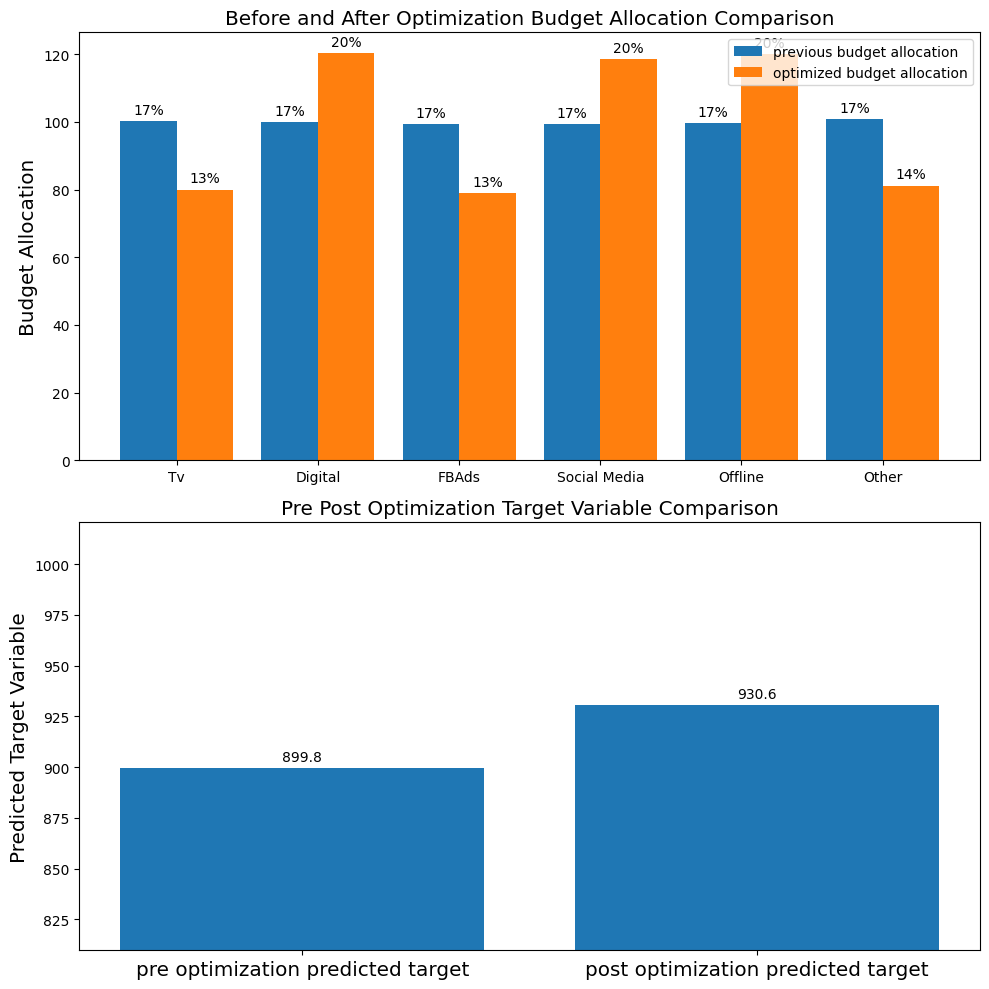

In [244]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=solution['fun'],
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation,
                                                previous_budget_allocation=previous_budget_allocation,
                                                figure_size=(10,10))